In [25]:
# Core Libraries
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Deep Learning
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM, Dropout
from tensorflow.keras.callbacks import EarlyStopping
# Import callbacks required for training
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# Ignore warnings
import warnings
warnings.filterwarnings("ignore")


In [2]:
# Load Tesla stock price dataset
df = pd.read_csv("../data/Tesla.csv")

# Display first few rows
df.head()


,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-06-29,19.000000,25.00,17.540001,23.889999,23.889999,18766300
1,2010-06-30,25.790001,30.42,23.299999,23.830000,23.830000,17187100
2,2010-07-01,25.000000,25.92,20.270000,21.959999,21.959999,8218800
3,2010-07-02,23.000000,23.10,18.709999,19.200001,19.200001,5139800
4,2010-07-06,20.000000,20.00,15.830000,16.110001,16.110001,6866900


In [3]:
# Basic information
df.info()

# Statistical summary
df.describe()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2416 entries, 0 to 2415
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       2416 non-null   object 
 1   Open       2416 non-null   float64
 2   High       2416 non-null   float64
 3   Low        2416 non-null   float64
 4   Close      2416 non-null   float64
 5   Adj Close  2416 non-null   float64
 6   Volume     2416 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 132.2+ KB


,Open,High,Low,Close,Adj Close,Volume
count,2416.000000,2416.000000,2416.000000,2416.000000,2416.000000,2.416000e+03
mean,186.271147,189.578224,182.916639,186.403651,186.403651,5.572722e+06
std,118.740163,120.892329,116.857591,119.136020,119.136020,4.987809e+06
min,16.139999,16.629999,14.980000,15.800000,15.800000,1.185000e+05
25%,34.342498,34.897501,33.587501,34.400002,34.400002,1.899275e+06
50%,213.035004,216.745002,208.870002,212.960007,212.960007,4.578400e+06
75%,266.450012,270.927513,262.102501,266.774994,266.774994,7.361150e+06
max,673.690002,786.140015,673.520020,780.000000,780.000000,4.706500e+07


In [4]:
# Check missing values
df.isnull().sum()


Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [5]:
df.fillna(method="ffill", inplace=True)
df.isnull().sum()


Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [6]:
# Convert Date column to datetime
df['Date'] = pd.to_datetime(df['Date'])

# Set Date as index
df.set_index('Date', inplace=True)

# Select target variable (Adj Close)
data = df[['Adj Close']]
data.head()


,Adj Close
Date,
2010-06-29,23.889999
2010-06-30,23.830000
2010-07-01,21.959999
2010-07-02,19.200001
2010-07-06,16.110001


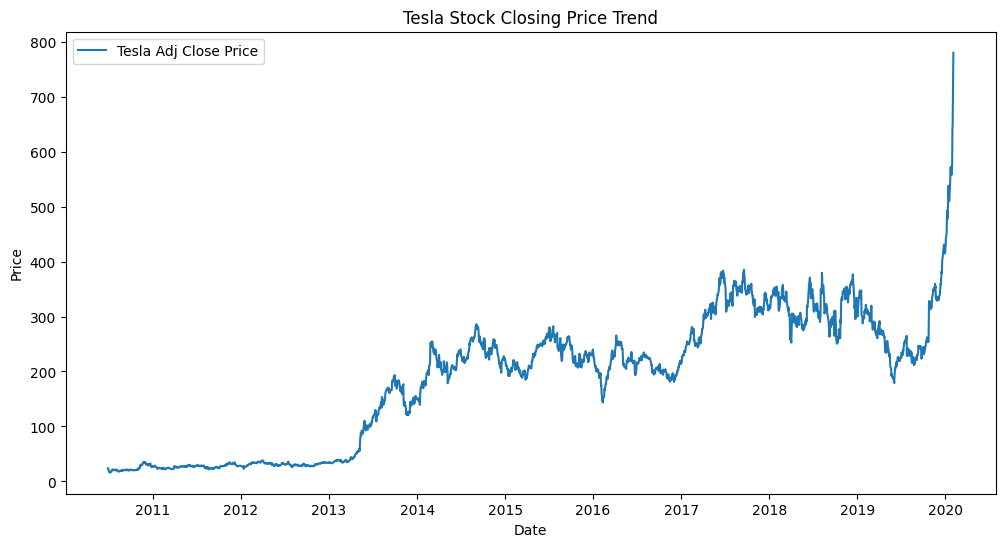

In [7]:
plt.figure(figsize=(12,6))
plt.plot(data, label='Tesla Adj Close Price')
plt.title("Tesla Stock Closing Price Trend")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show()


In [8]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(data)


In [9]:
train_size = int(len(scaled_data) * 0.8)

train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]


In [10]:
#Create Time-Series Sequences (Reusable for 1, 5, 10 days)
def create_sequences(data, window_size):
    X, y = [], []
    for i in range(window_size, len(data)):
        X.append(data[i-window_size:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)


In [11]:
# Preparing data for day 1
WINDOW_SIZE = 60  # past 60 days

X_train, y_train = create_sequences(train_data, WINDOW_SIZE)
X_test, y_test = create_sequences(test_data, WINDOW_SIZE)

# Reshape for RNN/LSTM
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))


In [12]:
# Initialize a Sequential model
# Sequential allows us to stack layers one after another
simple_rnn_model = Sequential()

# Add a SimpleRNN layer
# - 50 units (neurons) to learn temporal patterns
# - input_shape = (timesteps, features)
# - return_sequences=False because this is the last RNN layer
simple_rnn_model.add(
    SimpleRNN(
        units=50,
        return_sequences=False,
        input_shape=(X_train.shape[1], 1)
    )
)

# Dropout layer to prevent overfitting
# Randomly drops 20% of neurons during training
simple_rnn_model.add(Dropout(0.2))

# Dense output layer
# Outputs a single value (next day closing price)
simple_rnn_model.add(Dense(1))

# Display model architecture
simple_rnn_model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 50)                2600      
                                                                 
 dropout (Dropout)           (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 2651 (10.36 KB)
Trainable params: 2651 (10.36 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [13]:
# Compile the model
# - Optimizer: Adam (adaptive learning rate, good for time-series)
# - Loss: Mean Squared Error (standard for regression problems)
simple_rnn_model.compile(
    optimizer='adam',
    loss='mean_squared_error'
)


In [14]:
# EarlyStopping stops training when validation loss stops improving
# Helps prevent overfitting
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,               # wait for 10 epochs before stopping
    restore_best_weights=True  # restore best model weights
)

# ModelCheckpoint saves the best model during training
checkpoint = ModelCheckpoint(
    "../models/simple_rnn_model.h5",
    monitor='val_loss',
    save_best_only=True
)


In [15]:
# Train the SimpleRNN model
# - epochs: maximum training iterations
# - batch_size: number of samples per gradient update
# - validation_split: 10% of training data used for validation
history_rnn = simple_rnn_model.fit(
    X_train,
    y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.1,
    callbacks=[early_stop, checkpoint],
    verbose=1
)


Epoch 1/50
53/53 [==============================] - 1s 10ms/step - loss: 0.0087 - val_loss: 0.0029
Epoch 2/50
53/53 [==============================] - 0s 6ms/step - loss: 0.0012 - val_loss: 0.0013
Epoch 3/50
53/53 [==============================] - 0s 6ms/step - loss: 9.7195e-04 - val_loss: 5.7175e-04
Epoch 4/50
53/53 [==============================] - 0s 5ms/step - loss: 8.4209e-04 - val_loss: 8.1663e-04
Epoch 5/50
53/53 [==============================] - 0s 5ms/step - loss: 6.6180e-04 - val_loss: 2.6247e-04
Epoch 6/50
53/53 [==============================] - 0s 5ms/step - loss: 5.9433e-04 - val_loss: 4.4539e-04
Epoch 7/50
53/53 [==============================] - 0s 5ms/step - loss: 5.6883e-04 - val_loss: 2.8100e-04
Epoch 8/50
53/53 [==============================] - 0s 5ms/step - loss: 5.5201e-04 - val_loss: 1.9160e-04
Epoch 9/50
53/53 [==============================] - 0s 5ms/step - loss: 5.3753e-04 - val_loss: 1.9714e-04
Epoch 10/50
53/53 [==============================] - 0s 5ms/s

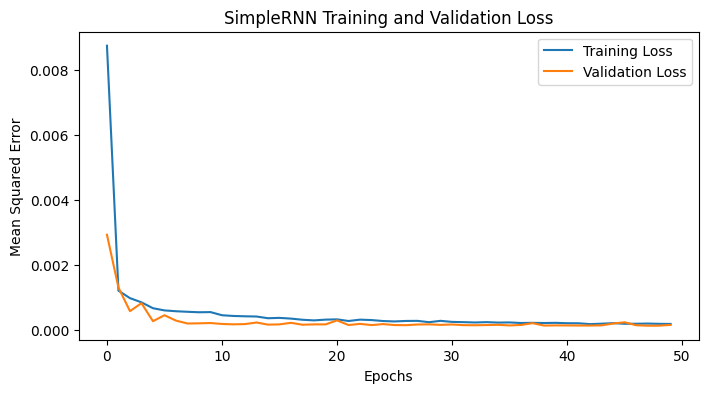

In [16]:
# Plot training and validation loss to visualize learning behavior
plt.figure(figsize=(8,4))
plt.plot(history_rnn.history['loss'], label='Training Loss')
plt.plot(history_rnn.history['val_loss'], label='Validation Loss')
plt.title("SimpleRNN Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Mean Squared Error")
plt.legend()
plt.show()


In [17]:
# Predict closing prices on test data
rnn_predictions = simple_rnn_model.predict(X_test)


14/14 [==============================] - 0s 2ms/step


In [18]:
# Convert scaled predictions back to original price range
rnn_predictions = scaler.inverse_transform(
    rnn_predictions.reshape(-1, 1)
)

# Convert actual test values back to original price range
y_test_actual = scaler.inverse_transform(
    y_test.reshape(-1, 1)
)


In [19]:
# Calculate Mean Squared Error for SimpleRNN
rnn_mse = mean_squared_error(y_test_actual, rnn_predictions)

print("SimpleRNN Mean Squared Error:", rnn_mse)


SimpleRNN Mean Squared Error: 203.0853279811976


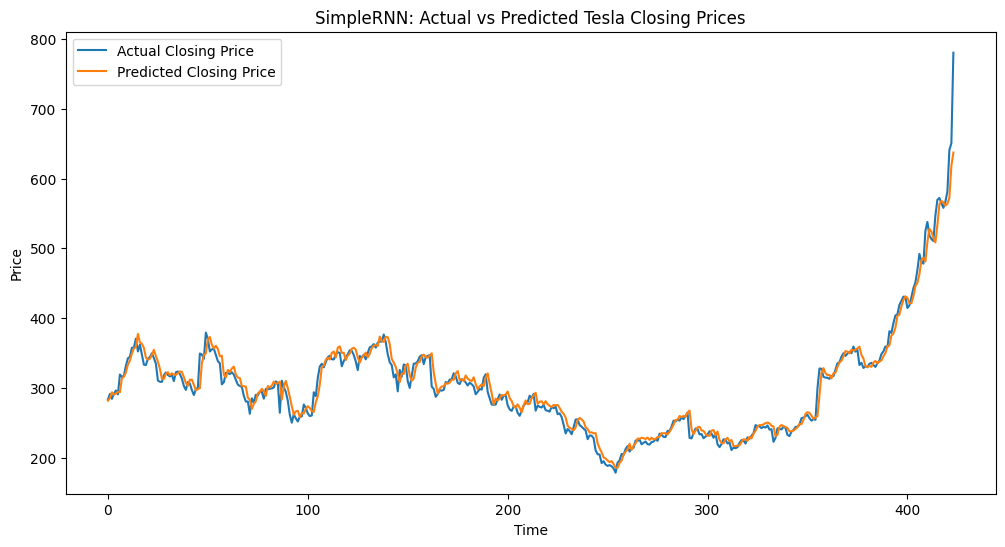

In [20]:
# Plot actual vs predicted closing prices
plt.figure(figsize=(12,6))
plt.plot(y_test_actual, label='Actual Closing Price')
plt.plot(rnn_predictions, label='Predicted Closing Price')
plt.title("SimpleRNN: Actual vs Predicted Tesla Closing Prices")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()
plt.show()


In [21]:
# -------------------------------
# Create Time-Series Sequences
# -------------------------------

import numpy as np

def create_sequences(data, time_steps=60):
    """
    Creates input-output sequences for RNN/LSTM models
    
    Parameters:
    data (array): Scaled stock prices
    time_steps (int): Number of previous days used for prediction
    
    Returns:
    X (array): Input sequences
    y (array): Target values
    """
    X, y = [], []
    
    for i in range(time_steps, len(data)):
        X.append(data[i - time_steps:i, 0])
        y.append(data[i, 0])
    
    return np.array(X), np.array(y)

# Create sequences
TIME_STEPS = 60
X, y = create_sequences(scaled_data, TIME_STEPS)

# Reshape for RNN/LSTM: (samples, time_steps, features)
X = X.reshape(X.shape[0], X.shape[1], 1)

print("X shape:", X.shape)
print("y shape:", y.shape)


X shape: (2356, 60, 1)
y shape: (2356,)


In [22]:
# -------------------------------
# Train / Validation / Test Split
# -------------------------------

from sklearn.model_selection import train_test_split

# First split: Train + Validation and Test
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size=0.15, shuffle=False
)

# Second split: Train and Validation
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.15, shuffle=False
)

print("Training shape:", X_train.shape)
print("Validation shape:", X_val.shape)
print("Test shape:", X_test.shape)


Training shape: (1701, 60, 1)
Validation shape: (301, 60, 1)
Test shape: (354, 60, 1)


In [23]:
# ===============================
# LSTM MODEL – TESLA STOCK PRICE
# ===============================

# Import required deep learning libraries
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# -------------------------------
# Build LSTM Model Architecture
# -------------------------------

lstm_model = Sequential()

# First LSTM layer with return_sequences=True
lstm_model.add(
    LSTM(
        units=50,
        return_sequences=True,
        input_shape=(X_train.shape[1], X_train.shape[2])
    )
)
lstm_model.add(Dropout(0.2))

# Second LSTM layer
lstm_model.add(
    LSTM(
        units=50,
        return_sequences=False
    )
)
lstm_model.add(Dropout(0.2))

# Output layer for regression (predict stock price)
lstm_model.add(Dense(1))

# -------------------------------
# Compile the model
# -------------------------------

lstm_model.compile(
    optimizer='adam',
    loss='mean_squared_error'
)

# Display model summary
lstm_model.summary()

# -------------------------------
# Callbacks
# -------------------------------

early_stop_lstm = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

checkpoint_lstm = ModelCheckpoint(
    "../models/lstm_model.h5",
    monitor='val_loss',
    save_best_only=True
)

# -------------------------------
# Train the LSTM Model
# -------------------------------

history_lstm = lstm_model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stop_lstm, checkpoint_lstm],
    verbose=1
)


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 50)            10400     
                                                                 
 dropout_1 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_1 (LSTM)               (None, 50)                20200     
                                                                 
 dropout_2 (Dropout)         (None, 50)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
Total params: 30651 (119.73 KB)
Trainable params: 30651 (119.73 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/50
54/54

In [26]:
# Predict using SimpleRNN
rnn_predictions = simple_rnn_model.predict(X_test)

# Inverse scaling to get real stock prices
rnn_predictions = scaler.inverse_transform(rnn_predictions)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))


12/12 [==============================] - 0s 2ms/step


In [27]:
# Predict using LSTM
lstm_predictions = lstm_model.predict(X_test)

# Inverse scaling
lstm_predictions = scaler.inverse_transform(lstm_predictions)


12/12 [==============================] - 0s 8ms/step


In [28]:
# SimpleRNN Metrics
rnn_rmse = np.sqrt(mean_squared_error(y_test_actual, rnn_predictions))
rnn_mae = mean_absolute_error(y_test_actual, rnn_predictions)

# LSTM Metrics
lstm_rmse = np.sqrt(mean_squared_error(y_test_actual, lstm_predictions))
lstm_mae = mean_absolute_error(y_test_actual, lstm_predictions)

print("SimpleRNN RMSE:", rnn_rmse)
print("SimpleRNN MAE :", rnn_mae)

print("\nLSTM RMSE:", lstm_rmse)
print("LSTM MAE :", lstm_mae)


SimpleRNN RMSE: 14.396150774178054
SimpleRNN MAE : 8.809544153276173

LSTM RMSE: 19.07720879700494
LSTM MAE : 12.485556731210828


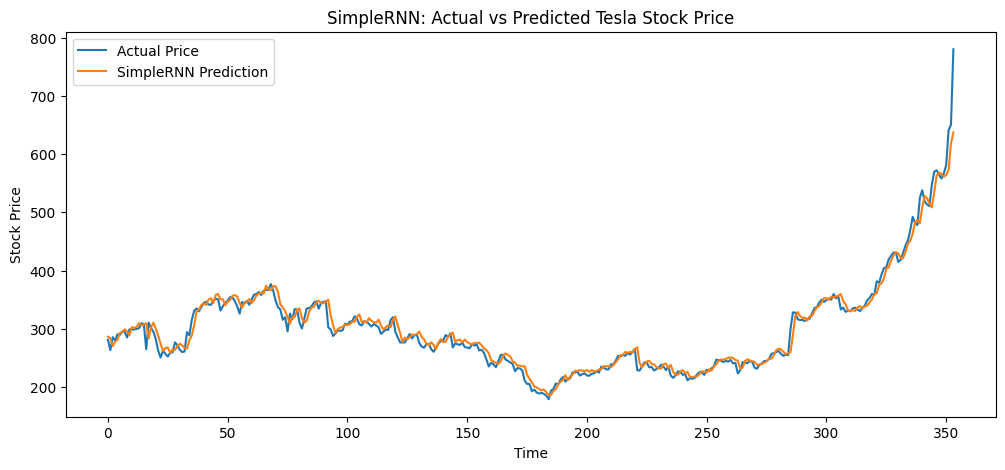

In [ ]:
# Simple RNN plot
plt.figure(figsize=(12,5))
plt.plot(y_test_actual, label="Actual Price")
plt.plot(rnn_predictions, label="SimpleRNN Prediction")
plt.title("SimpleRNN: Actual vs Predicted Tesla Stock Price")
plt.xlabel("Time")
plt.ylabel("Stock Price")
plt.legend()
plt.show()


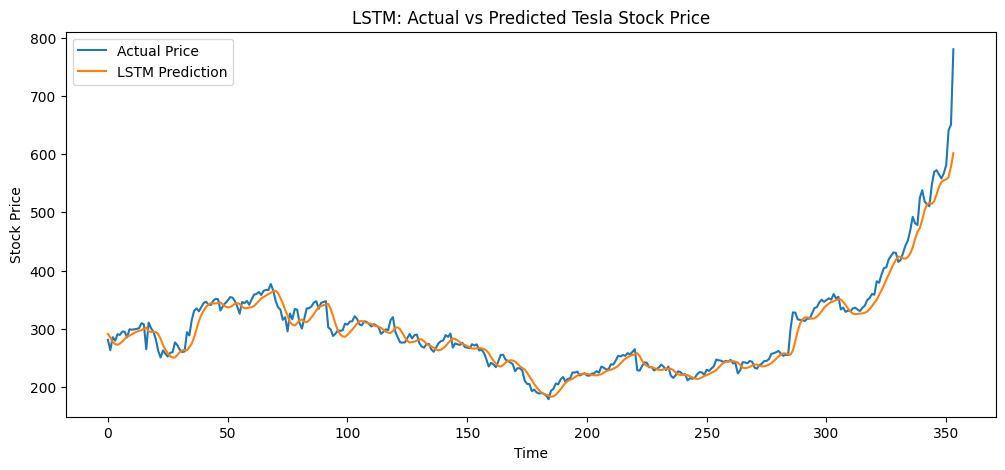

In [30]:
#LSTM Plot
plt.figure(figsize=(12,5))
plt.plot(y_test_actual, label="Actual Price")
plt.plot(lstm_predictions, label="LSTM Prediction")
plt.title("LSTM: Actual vs Predicted Tesla Stock Price")
plt.xlabel("Time")
plt.ylabel("Stock Price")
plt.legend()
plt.show()


In [ ]:
# STEP 7.1: Load the Best Trained LSTM Model

from tensorflow.keras.models import load_model

# Load the saved LSTM model
lstm_model = load_model("../models/lstm_model.h5")

print("LSTM model loaded successfully")


LSTM model loaded successfully


In [32]:
# STEP 7.2: Prepare Input Sequence for Forecasting

import numpy as np

# Take the last 60 days from the scaled dataset
last_60_days = scaled_data[-60:]

# Reshape to model input format: (1, time_steps, features)
last_60_days = last_60_days.reshape(1, 60, 1)

print("Input shape for prediction:", last_60_days.shape)


Input shape for prediction: (1, 60, 1)


In [33]:
# STEP 7.3: Multi-Day Forecast Function

def predict_future_days(model, last_sequence, n_days):
    """
    Predict stock prices for n future days using rolling window method
    """
    future_predictions = []
    current_sequence = last_sequence.copy()

    for _ in range(n_days):
        # Predict next day
        next_price = model.predict(current_sequence, verbose=0)[0, 0]
        future_predictions.append(next_price)

        # Update sequence: remove first value and append predicted value
        current_sequence = np.append(
            current_sequence[:, 1:, :],
            [[[next_price]]],
            axis=1
        )

    return future_predictions


In [34]:
# STEP 7.4: Generate Future Predictions

# Predict future prices
pred_1_day = predict_future_days(lstm_model, last_60_days, 1)
pred_5_days = predict_future_days(lstm_model, last_60_days, 5)
pred_10_days = predict_future_days(lstm_model, last_60_days, 10)

print("1-Day Prediction (Scaled):", pred_1_day)
print("5-Day Predictions (Scaled):", pred_5_days)
print("10-Day Predictions (Scaled):", pred_10_days)


1-Day Prediction (Scaled): [0.849445]
5-Day Predictions (Scaled): [0.849445, 0.8822733, 0.9002833, 0.9101597, 0.91521794]
10-Day Predictions (Scaled): [0.849445, 0.8822733, 0.9002833, 0.9101597, 0.91521794, 0.91716754, 0.91693556, 0.91506183, 0.91188985, 0.9076636]


In [35]:
# STEP 7.5: Convert Predictions Back to Original Price

# Inverse transform predictions
pred_1_day_actual = scaler.inverse_transform(
    np.array(pred_1_day).reshape(-1, 1)
)

pred_5_days_actual = scaler.inverse_transform(
    np.array(pred_5_days).reshape(-1, 1)
)

pred_10_days_actual = scaler.inverse_transform(
    np.array(pred_10_days).reshape(-1, 1)
)

print("\n📈 Actual Stock Price Predictions:")
print("1-Day Ahead:", pred_1_day_actual.flatten())
print("5-Day Ahead:", pred_5_days_actual.flatten())
print("10-Day Ahead:", pred_10_days_actual.flatten())



📈 Actual Stock Price Predictions:
1-Day Ahead: [664.94586]
5-Day Ahead: [664.94586 690.03326 703.7965  711.34406 715.2096 ]
10-Day Ahead: [664.94586 690.03326 703.7965  711.34406 715.2096  716.69946 716.52216
 715.0903  712.66626 709.4365 ]


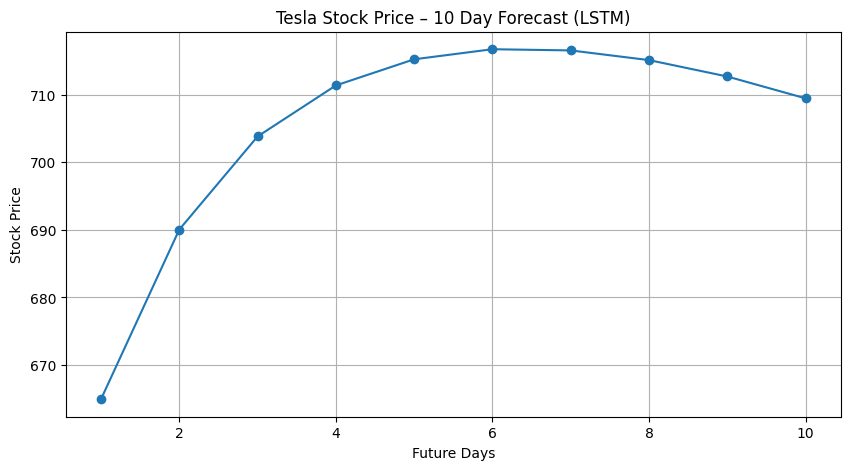

In [36]:
# STEP 7.6: Plot Future Forecast

import matplotlib.pyplot as plt

# Create future day index
future_days = list(range(1, 11))

plt.figure(figsize=(10, 5))
plt.plot(future_days, pred_10_days_actual, marker='o')
plt.title("Tesla Stock Price – 10 Day Forecast (LSTM)")
plt.xlabel("Future Days")
plt.ylabel("Stock Price")
plt.grid(True)
plt.show()


In [37]:
# STEP 8.1: Load Trained Models

from tensorflow.keras.models import load_model

# Load SimpleRNN model
simple_rnn_model = load_model("../models/simple_rnn_model.h5")

# Load LSTM model
lstm_model = load_model("../models/lstm_model.h5")

print("Both models loaded successfully")


Both models loaded successfully


In [38]:
# STEP 8.2: Model Predictions

# Predict using SimpleRNN
rnn_predictions = simple_rnn_model.predict(X_test)

# Predict using LSTM
lstm_predictions = lstm_model.predict(X_test)


12/12 [==============================] - 0s 8ms/step


In [39]:
# STEP 8.3: Convert Predictions to Original Scale

# Inverse transform predictions
rnn_predictions_actual = scaler.inverse_transform(rnn_predictions)
lstm_predictions_actual = scaler.inverse_transform(lstm_predictions)

# Inverse transform actual test values
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))


In [ ]:
# STEP 8.4: Calculate RMSE

# RMSE for SimpleRNN
rnn_rmse = np.sqrt(mean_squared_error(y_test_actual, rnn_predictions_actual))

# RMSE for LSTM
lstm_rmse = np.sqrt(mean_squared_error(y_test_actual, lstm_predictions_actual))

print(f"📉 SimpleRNN RMSE: {rnn_rmse}")
print(f"📉 LSTM RMSE: {lstm_rmse}")


📉 SimpleRNN RMSE: 14.76659486727303
📉 LSTM RMSE: 17.936067035708575


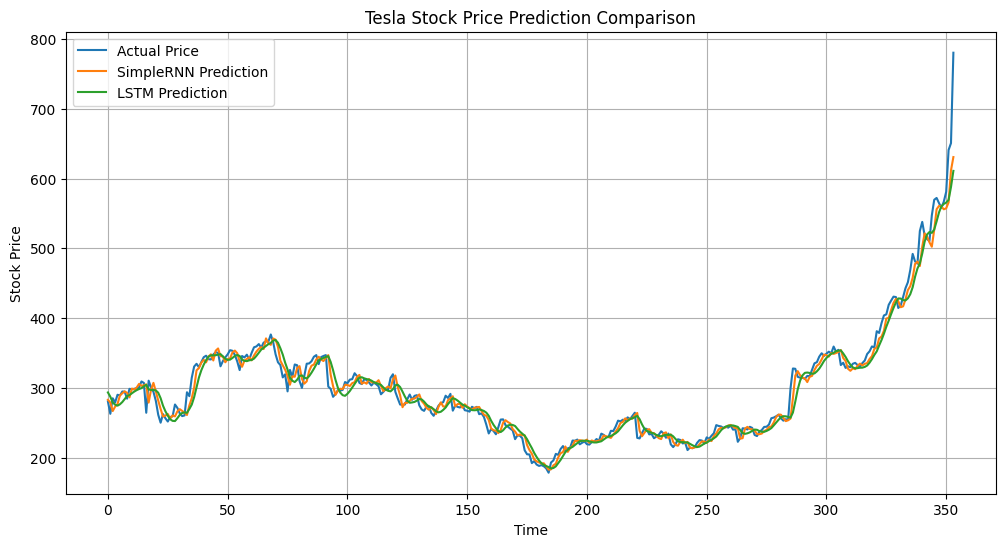

In [41]:
# STEP 8.5: Plot Predictions

plt.figure(figsize=(12, 6))

# Actual prices
plt.plot(y_test_actual, label="Actual Price")

# SimpleRNN predictions
plt.plot(rnn_predictions_actual, label="SimpleRNN Prediction")

# LSTM predictions
plt.plot(lstm_predictions_actual, label="LSTM Prediction")

plt.title("Tesla Stock Price Prediction Comparison")
plt.xlabel("Time")
plt.ylabel("Stock Price")
plt.legend()
plt.grid(True)
plt.show()


In [2]:
import tensorflow as tf
print(tf.__version__)


2.20.0
